In [ ]:
#Import SparkSession
from pyspark.sql import SparkSession

#Initialize a SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
print(spark)


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as metrics
from pyspark.sql import functions as F
from pprint import pprint
import requests
import os

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("_id", IntegerType(), True),
    StructField("REPORT_YEAR", IntegerType(), True),
    StructField("DIVISION", StringType(), True),
    StructField("CATEGORY", StringType(), True),
    StructField("SUBTYPE", StringType(), True),
    StructField("COUNT_", IntegerType(), True),
    StructField("COUNT_CLEARED", IntegerType(), True)
])

crime_df = spark.read.csv("Reported Crimes.csv", schema=schema)

In [ ]:
crime_df =  spark.read.csv("Reported Crimes.csv", header= True, inferSchema = True)

In [ ]:
crime_df.show()

+---+-----------+--------+--------------------+--------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|             SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+--------------------+------+-------------+
|  1|       2022|     D32|Crimes Against Pr...|          Auto Theft|    79|            0|
|  2|       2023|     D12|Crimes Against Pr...| Break & Enter-House|     1|            0|
|  3|       2014|     D13|Crimes Against Pr...|          Auto Theft|     7|            0|
|  4|       2021|     NSA|Crimes Against th...|    Sexual Violation|     1|            0|
|  5|       2020|     D53|Crimes Against Pr...|Break & Enter-Apa...|     2|            0|
|  6|       2017|     D43|Crimes Against Pr...|Break & Enter-Apa...|     1|            0|
|  7|       2023|     D22|Crimes Against Pr...|   Theft Under $5000|     3|            0|
|  8|       2018|     D33|Crimes Against Pr...| Break & Enter-Other|     1|            0|
|  9|     

In [ ]:
crime_df.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- REPORT_YEAR: integer (nullable = true)
 |-- DIVISION: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- SUBTYPE: string (nullable = true)
 |-- COUNT_: integer (nullable = true)
 |-- COUNT_CLEARED: integer (nullable = true)



In [ ]:
#Analysis
row_count = crime_df.count()
print(f'Number of rows: {row_count}')
crime_stats = crime_df.groupBy('CATEGORY', 'SUBTYPE').agg(
    F.sum('COUNT_').alias('total_count'),
    F.avg('COUNT_').alias('avg_count'),
    F.min('COUNT_').alias('min_count'),
    F.max('COUNT_').alias('max_count')
)
crime_stats.show()

Number of rows: 32000
+--------------------+--------------------+-----------+------------------+---------+---------+
|            CATEGORY|             SUBTYPE|total_count|         avg_count|min_count|max_count|
+--------------------+--------------------+-----------+------------------+---------+---------+
|Other Federal Sta...|               Other|       2049|2.3715277777777777|        1|       20|
|Crimes Against th...|               Other|      36409| 20.45449438202247|        1|      167|
|Crimes Against Pr...|               Fraud|      91223|  46.6613810741688|        1|      506|
|Crimes Against Pr...|Break & Enter-Apa...|      16063|10.089824120603016|        1|       99|
|Crimes Against th...|   Robbery-Financial|        734|1.8724489795918366|        1|       29|
|Crimes Against Pr...|    Theft Over $5000|      10881| 6.260644418872267|        1|       62|
|Crimes Against Pr...|          Auto Theft|      51122|27.889798145117293|        1|      835|
|Crimes Against Pr...| Break

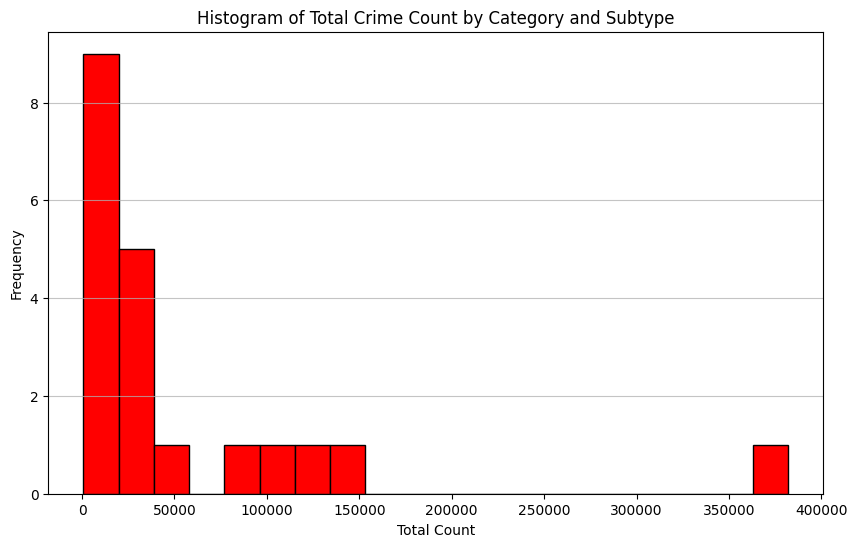

In [ ]:
crime_stats_pd = crime_stats.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(crime_stats_pd['total_count'], bins=20, color='red', edgecolor='black')
plt.title('Histogram of Total Crime Count by Category and Subtype')
plt.xlabel('Total Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
Robbery_Financial_avg = crime_df.filter(crime_df['SUBTYPE']=="Robbery-Financial").groupBy().avg('COUNT_')
Robbery_Financial_avg.show()

+------------------+
|       avg(COUNT_)|
+------------------+
|1.8724489795918366|
+------------------+



In [ ]:
filtered_crime_df =  crime_df.filter(crime_df['DIVISION']> 'D50').select('DIVISION', 'CATEGORY', 'SUBTYPE')
filtered_crime_df.show()

+--------+--------------------+--------------------+
|DIVISION|            CATEGORY|             SUBTYPE|
+--------+--------------------+--------------------+
|     NSA|Crimes Against th...|    Sexual Violation|
|     D53|Crimes Against Pr...|Break & Enter-Apa...|
|     D55|Crimes Against th...|    Sexual Violation|
|     D52|Crimes Against Pr...| Break & Enter-House|
|     D53|Crimes Against Pr...|Break & Enter-Apa...|
|     D52|Crimes Against th...|    Sexual Violation|
|     D55|Crimes Against Pr...| Break & Enter-Other|
|     NSA|Crimes Against Pr...|               Other|
|     D55|Crimes Against Pr...|          Auto Theft|
|     D53|Crimes Against Pr...| Break & Enter-House|
|     D55|Crimes Against Pr...|    Theft Over $5000|
|     NSA|Crimes Against Pr...|    Theft Over $5000|
|     D53|Crimes Against Pr...|          Auto Theft|
|     D55|Crimes Against th...|       Robbery-Other|
|     D55|Crimes Against Pr...|Break & Enter-Apa...|
|     D53|Crimes Against Pr...|Break & Enter-C

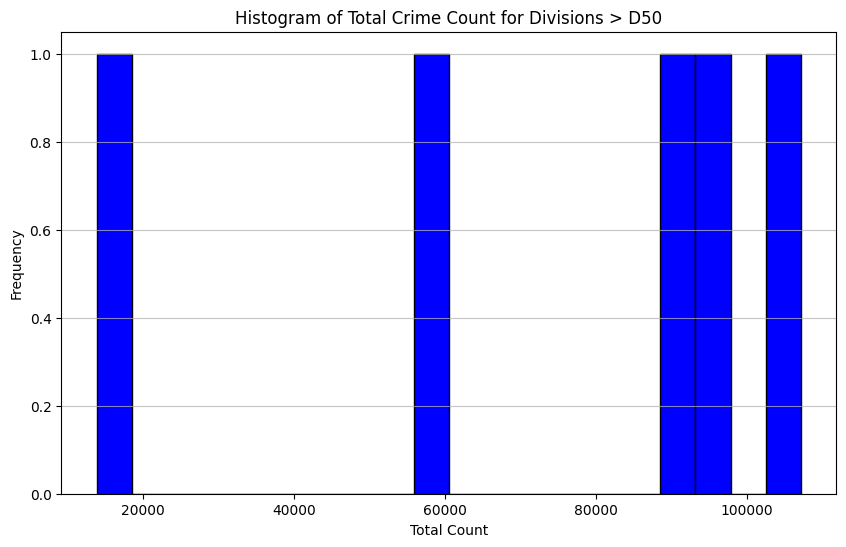

In [ ]:
filtered_division_counts = crime_df.filter(crime_df['DIVISION'] > 'D50') \
                                   .groupBy('DIVISION') \
                                   .agg(F.sum('COUNT_').alias('total_count'))

filtered_crime_pd = filtered_division_counts.toPandas()

# Create a histogram of 'total_count'
plt.figure(figsize=(10, 6))
plt.hist(filtered_crime_pd['total_count'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Total Crime Count for Divisions > D50')
plt.xlabel('Total Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

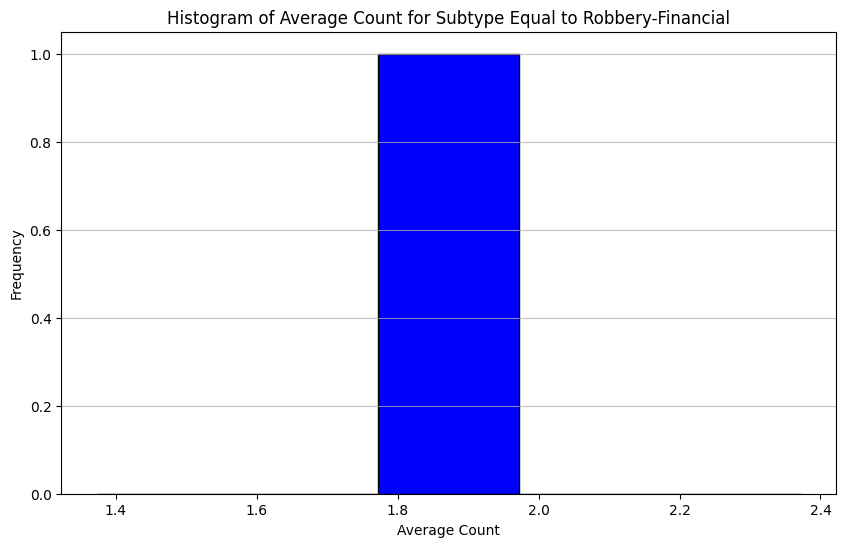

In [ ]:
filtered_subtype_pd = Robbery_Financial_avg.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_subtype_pd['avg(COUNT_)'], bins=5, color='blue', edgecolor='black')
plt.title('Histogram of Average Count for Subtype Equal to Robbery-Financial')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
crime_df.select("REPORT_YEAR","CATEGORY", "SUBTYPE", "COUNT_").show()

+-----------+--------------------+--------------------+------+
|REPORT_YEAR|            CATEGORY|             SUBTYPE|COUNT_|
+-----------+--------------------+--------------------+------+
|       2022|Crimes Against Pr...|          Auto Theft|    79|
|       2023|Crimes Against Pr...| Break & Enter-House|     1|
|       2014|Crimes Against Pr...|          Auto Theft|     7|
|       2021|Crimes Against th...|    Sexual Violation|     1|
|       2020|Crimes Against Pr...|Break & Enter-Apa...|     2|
|       2017|Crimes Against Pr...|Break & Enter-Apa...|     1|
|       2023|Crimes Against Pr...|   Theft Under $5000|     3|
|       2018|Crimes Against Pr...| Break & Enter-Other|     1|
|       2014|Crimes Against th...|    Sexual Violation|     1|
|       2022|Crimes Against Pr...|    Theft Over $5000|     2|
|       2021|Crimes Against Pr...|Break & Enter-Com...|     1|
|       2016|Crimes Against Pr...| Break & Enter-House|     1|
|       2017|Crimes Against Pr...|          Auto Theft|

In [ ]:
filtered_report_year= crime_df.filter((crime_df["REPORT_YEAR"] > 2022) & (crime_df["COUNT_"] > 50))
filtered_report_year.show()

+----+-----------+--------+--------------------+-----------------+------+-------------+
| _id|REPORT_YEAR|DIVISION|            CATEGORY|          SUBTYPE|COUNT_|COUNT_CLEARED|
+----+-----------+--------+--------------------+-----------------+------+-------------+
| 861|       2023|     D32|Crimes Against Pr...|            Fraud|    64|            0|
| 926|       2023|     D53|Crimes Against Pr...|            Fraud|    93|            0|
|1113|       2023|     D13|Crimes Against Pr...|       Auto Theft|    59|            0|
|2039|       2023|     D55|Crimes Against Pr...|            Fraud|    58|            0|
|2170|       2023|     D42|Crimes Against Pr...|       Auto Theft|    53|            0|
|2318|       2023|     D55|Crimes Against Pr...|       Auto Theft|    61|            0|
|2728|       2023|     D53|Crimes Against Pr...|            Fraud|    54|            0|
|3909|       2023|     D55|Crimes Against Pr...|       Auto Theft|    51|            0|
|4074|       2023|     D13|Crime

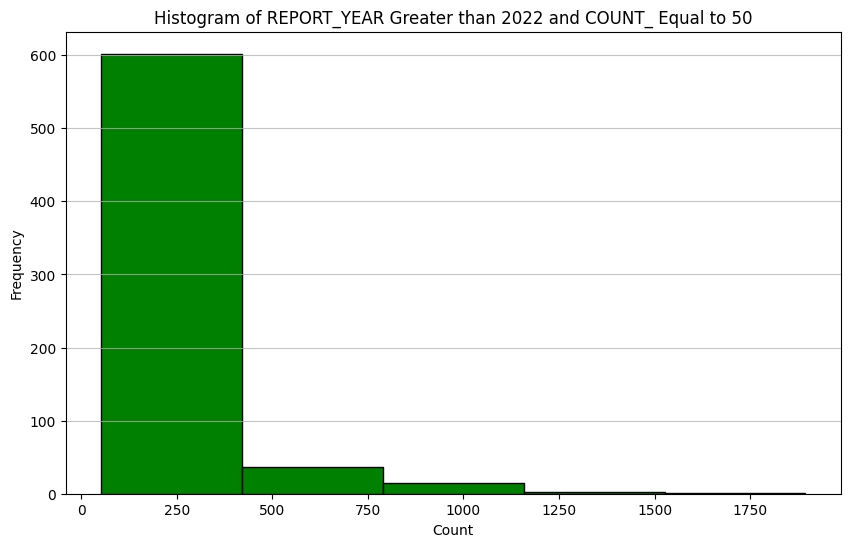

In [ ]:
filtered_report_year_pd = filtered_report_year.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_report_year_pd['COUNT_'], bins=5, color='green', edgecolor='black')
plt.title('Histogram of REPORT_YEAR Greater than 2022 and COUNT_ Equal to 50')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [78]:
filtered_crimes_against_property_tm5 = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against Property") &
    (crime_df["SUBTYPE"] == "Theft Over $5000")
)
filtered_crimes_against_property_tm5.show()

filtered_crimes_against_property = filtered_crimes_against_property_tm5.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property.show()

+---+-----------+--------+--------------------+----------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|         SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+----------------+------+-------------+
| 10|       2022|     D43|Crimes Against Pr...|Theft Over $5000|     2|            0|
| 32|       2019|     D41|Crimes Against Pr...|Theft Over $5000|     1|            0|
| 33|       2023|     D11|Crimes Against Pr...|Theft Over $5000|     2|            0|
| 34|       2023|     D14|Crimes Against Pr...|Theft Over $5000|     5|            0|
| 37|       2022|     D55|Crimes Against Pr...|Theft Over $5000|     3|            0|
| 39|       2023|     D32|Crimes Against Pr...|Theft Over $5000|     2|            0|
| 42|       2017|     NSA|Crimes Against Pr...|Theft Over $5000|     1|            0|
| 62|       2022|     D41|Crimes Against Pr...|Theft Over $5000|     4|            0|
| 66|       2016|     D31|Crimes Against Pr...|Theft O

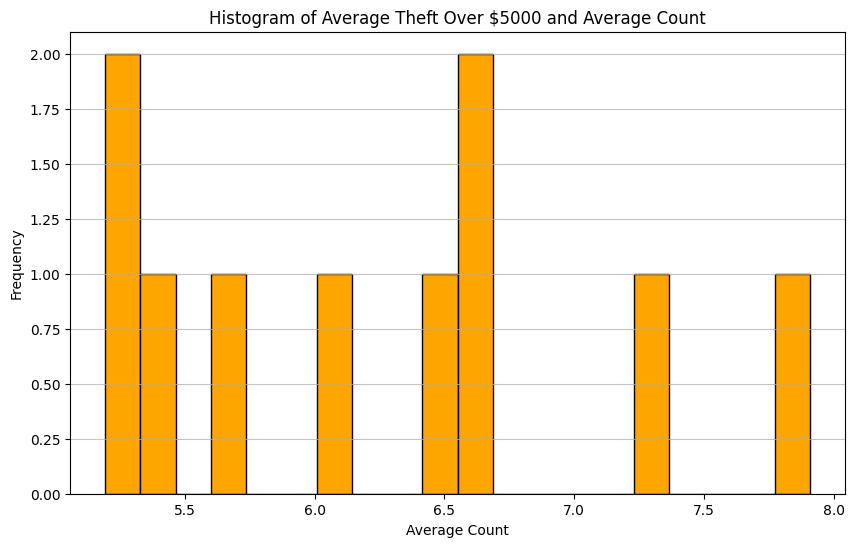

In [65]:
filtered_crimes_against_property_tm5_pd = filtered_crimes_against_property.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_property_tm5_pd['total_count'], bins=20, color='orange', edgecolor='black')
plt.title('Histogram of Average Theft Over $5000 and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [77]:
filtered_crimes_against_property_tl5 = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against Property") &
    (crime_df["SUBTYPE"] == "Theft Under $5000")
)
filtered_crimes_against_property_tl5.show()

filtered_crimes_against_property_2 = filtered_crimes_against_property_tl5.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_2.show()

+---+-----------+--------+--------------------+-----------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|          SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+-----------------+------+-------------+
|  7|       2023|     D22|Crimes Against Pr...|Theft Under $5000|     3|            0|
| 64|       2021|     D51|Crimes Against Pr...|Theft Under $5000|     1|            0|
| 74|       2019|     D22|Crimes Against Pr...|Theft Under $5000|     1|            0|
|111|       2017|     D33|Crimes Against Pr...|Theft Under $5000|     1|            0|
|115|       2019|     D14|Crimes Against Pr...|Theft Under $5000|     2|            0|
|117|       2020|     D53|Crimes Against Pr...|Theft Under $5000|     3|            0|
|160|       2016|     D22|Crimes Against Pr...|Theft Under $5000|     1|            0|
|166|       2023|     D41|Crimes Against Pr...|Theft Under $5000|     2|            0|
|172|       2018|     D23|Crimes Against Pr

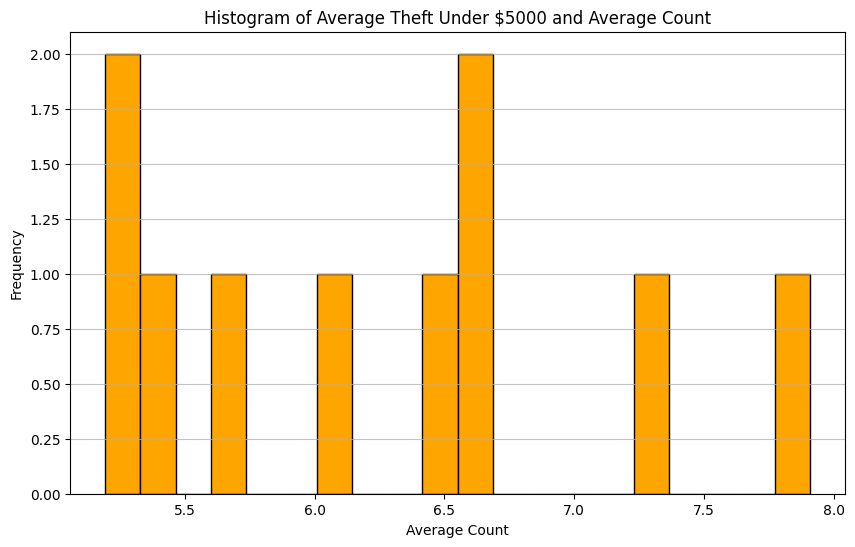

In [64]:
filtered_crimes_against_property_tl5_pd = filtered_crimes_against_property_2.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_property_tl5_pd['total_count'], bins=20, color='orange', edgecolor='black')
plt.title('Histogram of Average Theft Under $5000 and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [76]:
filtered_crimes_against_property_BEA = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against Property") &
    (crime_df["SUBTYPE"] == "Break & Enter-Apartment")
)
filtered_crimes_against_property_BEA.show()

filtered_crimes_against_property_3 = filtered_crimes_against_property_BEA.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_3.show()

+---+-----------+--------+--------------------+--------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|             SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+--------------------+------+-------------+
|  5|       2020|     D53|Crimes Against Pr...|Break & Enter-Apa...|     2|            0|
|  6|       2017|     D43|Crimes Against Pr...|Break & Enter-Apa...|     1|            0|
| 15|       2019|     D53|Crimes Against Pr...|Break & Enter-Apa...|     2|            0|
| 19|       2023|     D32|Crimes Against Pr...|Break & Enter-Apa...|     2|            0|
| 50|       2019|     D42|Crimes Against Pr...|Break & Enter-Apa...|     5|            0|
| 55|       2014|     D55|Crimes Against Pr...|Break & Enter-Apa...|     6|            0|
| 80|       2023|     D43|Crimes Against Pr...|Break & Enter-Apa...|     1|            0|
| 87|       2021|     D32|Crimes Against Pr...|Break & Enter-Apa...|    10|            0|
|103|     

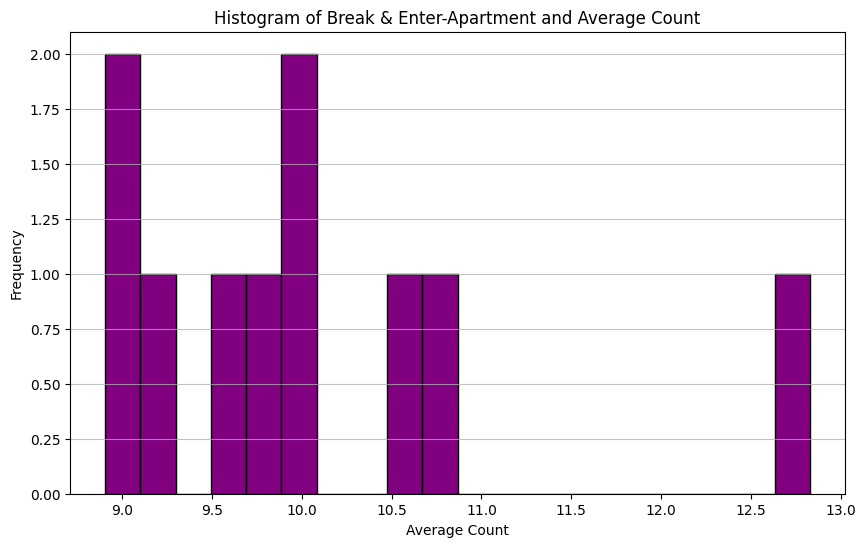

In [63]:
filtered_crimes_against_property_BEA_pd = filtered_crimes_against_property_3.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_property_BEA_pd['total_count'], bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Break & Enter-Apartment and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [75]:
filtered_crimes_against_property_BEC = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against Property") &
    (crime_df["SUBTYPE"] == "Break & Enter-Commercial")
)
filtered_crimes_against_property_BEC.show()

filtered_crimes_against_property_4 = filtered_crimes_against_property_BEC.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_4.show()

+---+-----------+--------+--------------------+--------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|             SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+--------------------+------+-------------+
| 11|       2021|     D23|Crimes Against Pr...|Break & Enter-Com...|     1|            0|
| 40|       2014|     D43|Crimes Against Pr...|Break & Enter-Com...|     2|            0|
| 52|       2019|     D23|Crimes Against Pr...|Break & Enter-Com...|     3|            0|
| 57|       2015|     D53|Crimes Against Pr...|Break & Enter-Com...|     8|            0|
| 59|       2015|     D11|Crimes Against Pr...|Break & Enter-Com...|     1|            0|
| 65|       2017|     D53|Crimes Against Pr...|Break & Enter-Com...|     1|            0|
| 92|       2018|     D33|Crimes Against Pr...|Break & Enter-Com...|     8|            0|
|110|       2020|     D41|Crimes Against Pr...|Break & Enter-Com...|     2|            0|
|119|     

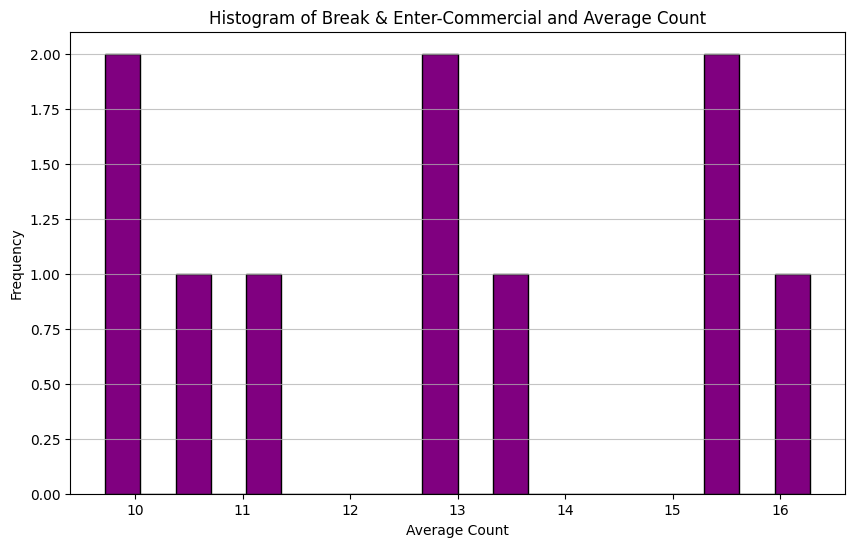

In [62]:
filtered_crimes_against_property_BEC_pd = filtered_crimes_against_property_4.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_property_BEC_pd['total_count'], bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Break & Enter-Commercial and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [74]:
filtered_crimes_against_property_BEH = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against Property") &
    (crime_df["SUBTYPE"] == "Break & Enter-House")
)
filtered_crimes_against_property_BEH.show()

filtered_crimes_against_property_5 = filtered_crimes_against_property_BEH.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_5.show()

+---+-----------+--------+--------------------+-------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|            SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+-------------------+------+-------------+
|  2|       2023|     D12|Crimes Against Pr...|Break & Enter-House|     1|            0|
| 12|       2016|     D52|Crimes Against Pr...|Break & Enter-House|     1|            0|
| 27|       2019|     D53|Crimes Against Pr...|Break & Enter-House|     1|            0|
| 30|       2020|     D22|Crimes Against Pr...|Break & Enter-House|     3|            0|
| 38|       2020|     D23|Crimes Against Pr...|Break & Enter-House|     1|            0|
| 44|       2017|     D33|Crimes Against Pr...|Break & Enter-House|     9|            0|
| 61|       2022|     D42|Crimes Against Pr...|Break & Enter-House|     9|            0|
| 68|       2020|     D55|Crimes Against Pr...|Break & Enter-House|    12|            0|
| 99|       2014|    

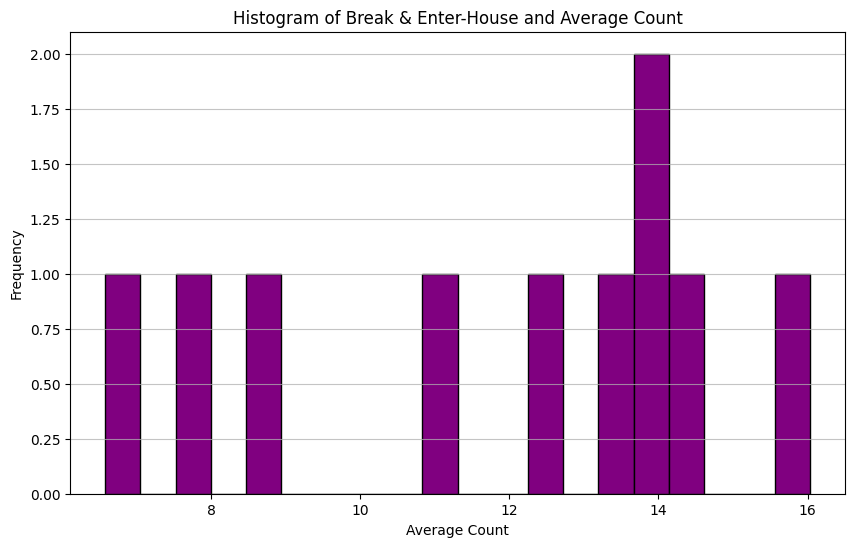

In [61]:
filtered_crimes_against_property_BEH_pd = filtered_crimes_against_property_5.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_property_BEH_pd['total_count'], bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Break & Enter-House and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [73]:
filtered_crimes_against_property_BEO = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against Property") &
    (crime_df["SUBTYPE"] == "Break & Enter-Other")
)
filtered_crimes_against_property_BEO.show()

filtered_crimes_against_property_6 = filtered_crimes_against_property_BEO.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_6.show()

+---+-----------+--------+--------------------+-------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|            SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+-------------------+------+-------------+
|  8|       2018|     D33|Crimes Against Pr...|Break & Enter-Other|     1|            0|
| 17|       2021|     D13|Crimes Against Pr...|Break & Enter-Other|     2|            0|
| 20|       2017|     D55|Crimes Against Pr...|Break & Enter-Other|     3|            0|
| 47|       2017|     D31|Crimes Against Pr...|Break & Enter-Other|     1|            0|
| 51|       2017|     D31|Crimes Against Pr...|Break & Enter-Other|     1|            0|
| 70|       2021|     D42|Crimes Against Pr...|Break & Enter-Other|     2|            0|
| 76|       2020|     D55|Crimes Against Pr...|Break & Enter-Other|     7|            0|
| 81|       2018|     D12|Crimes Against Pr...|Break & Enter-Other|     1|            0|
| 82|       2019|    

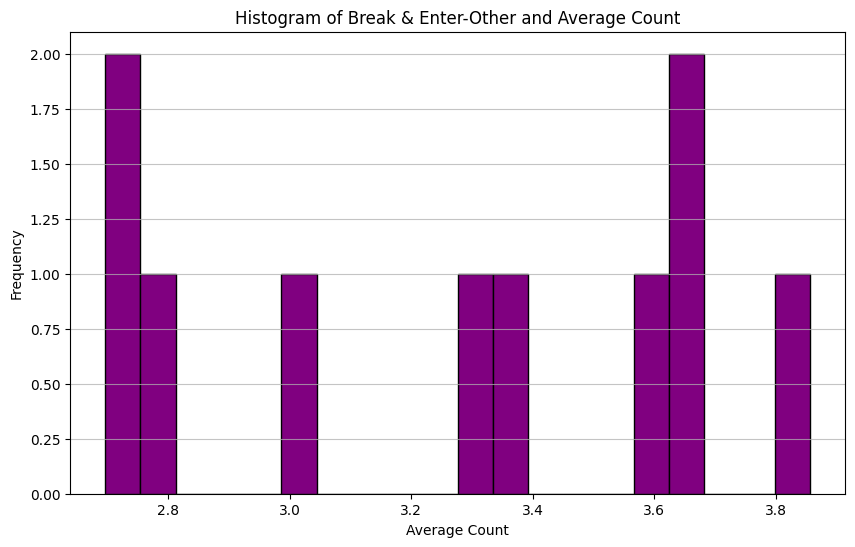

In [67]:
filtered_crimes_against_property_BEO_pd = filtered_crimes_against_property_6.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_property_BEO_pd['total_count'], bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Break & Enter-Other and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [72]:
filtered_crimes_against_property_AT = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against Property") &
    (crime_df["SUBTYPE"] == "Auto Theft")
)
filtered_crimes_against_property_AT.show()

filtered_crimes_against_property_7 = filtered_crimes_against_property_AT.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_7.show()

+---+-----------+--------+--------------------+----------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|   SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+----------+------+-------------+
|  1|       2022|     D32|Crimes Against Pr...|Auto Theft|    79|            0|
|  3|       2014|     D13|Crimes Against Pr...|Auto Theft|     7|            0|
| 13|       2017|     D11|Crimes Against Pr...|Auto Theft|     1|            0|
| 14|       2017|     D42|Crimes Against Pr...|Auto Theft|    13|            0|
| 22|       2015|     D55|Crimes Against Pr...|Auto Theft|    13|            0|
| 28|       2022|     D41|Crimes Against Pr...|Auto Theft|     5|            0|
| 29|       2021|     D14|Crimes Against Pr...|Auto Theft|    16|            0|
| 35|       2021|     D23|Crimes Against Pr...|Auto Theft|    21|            0|
| 41|       2019|     D33|Crimes Against Pr...|Auto Theft|    10|            0|
| 45|       2020|     D53|Crimes Against

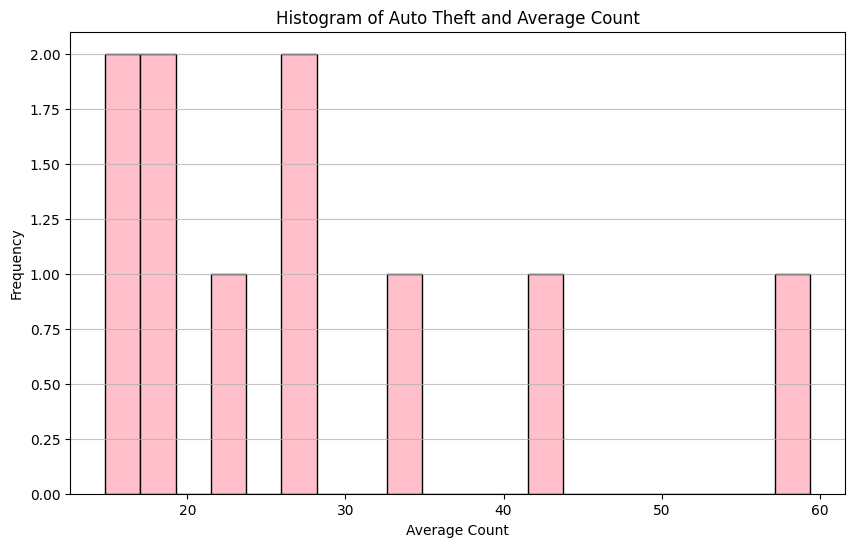

In [69]:
filtered_crimes_against_property_AT_pd = filtered_crimes_against_property_7.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_property_AT_pd['total_count'], bins=20, color='pink', edgecolor='black')
plt.title('Histogram of Auto Theft and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [70]:
filtered_crimes_against_person_SV = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against the Person") &
    (crime_df["SUBTYPE"] == "Sexual Violation")
)
filtered_crimes_against_person_SV.show()

filtered_crimes_against_property_8 = filtered_crimes_against_person_SV.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_8.show()

+---+-----------+--------+--------------------+----------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|         SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+----------------+------+-------------+
|  4|       2021|     NSA|Crimes Against th...|Sexual Violation|     1|            0|
|  9|       2014|     D55|Crimes Against th...|Sexual Violation|     1|            0|
| 18|       2018|     D52|Crimes Against th...|Sexual Violation|     2|            0|
| 24|       2015|     D13|Crimes Against th...|Sexual Violation|     2|            0|
| 63|       2022|     D13|Crimes Against th...|Sexual Violation|     1|            0|
| 75|       2017|     D52|Crimes Against th...|Sexual Violation|     1|            0|
|106|       2022|     D53|Crimes Against th...|Sexual Violation|     3|            0|
|134|       2022|     D23|Crimes Against th...|Sexual Violation|     2|            0|
|149|       2020|     D41|Crimes Against th...|Sexual 

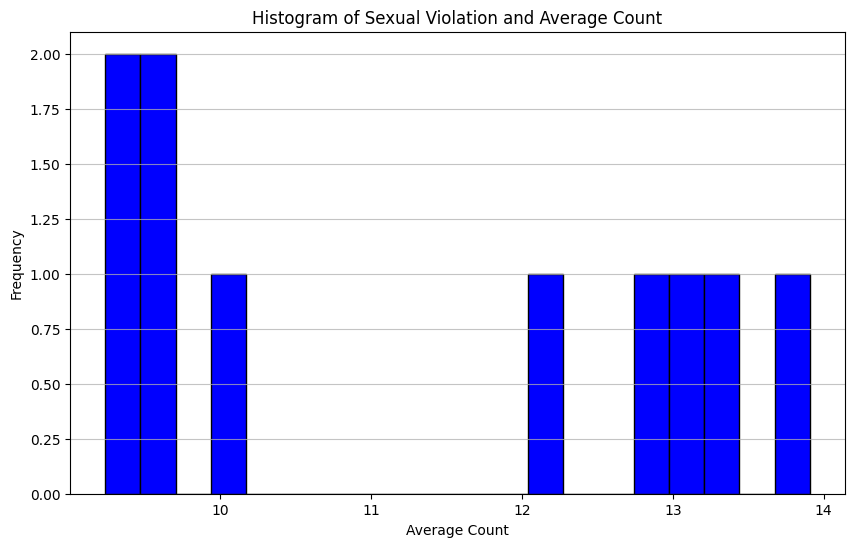

In [80]:
filtered_crimes_against_person_SV_pd = filtered_crimes_against_property_8.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_person_SV_pd['average_count'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Sexual Violation and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [81]:
filtered_crimes_against_person_AM = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against the Person") &
    (crime_df["SUBTYPE"] == "Attempt Murder")
)
filtered_crimes_against_person_AM.show()

filtered_crimes_against_property_9 = filtered_crimes_against_person_AM.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_9.show()

+---+-----------+--------+--------------------+--------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|       SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+--------------+------+-------------+
| 23|       2014|     D32|Crimes Against th...|Attempt Murder|     1|            0|
| 31|       2014|     D12|Crimes Against th...|Attempt Murder|     1|            0|
| 46|       2014|     D32|Crimes Against th...|Attempt Murder|     1|            0|
| 67|       2014|     D42|Crimes Against th...|Attempt Murder|     2|            0|
| 96|       2023|     D22|Crimes Against th...|Attempt Murder|     2|            0|
|104|       2018|     D43|Crimes Against th...|Attempt Murder|     1|            0|
|157|       2016|     D14|Crimes Against th...|Attempt Murder|     2|            0|
|245|       2018|     D32|Crimes Against th...|Attempt Murder|     1|            0|
|285|       2019|     D13|Crimes Against th...|Attempt Murder|     2|       

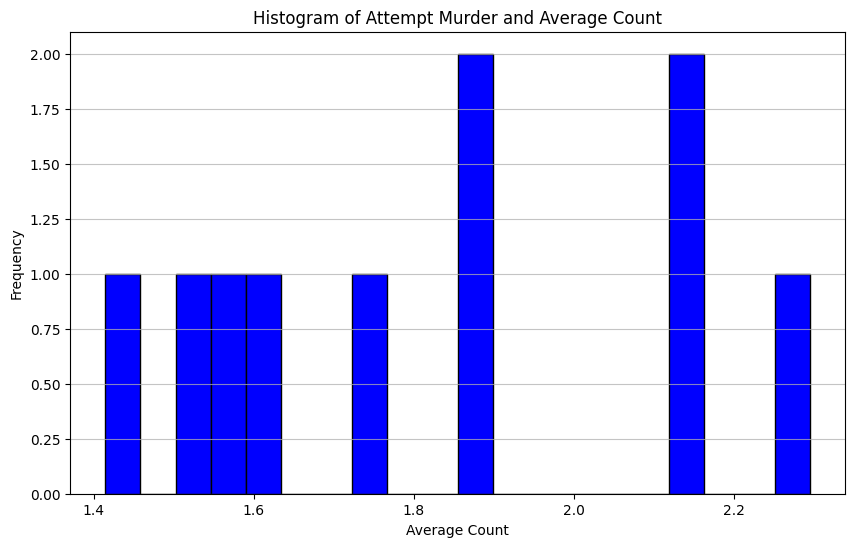

In [82]:
filtered_crimes_against_person_AM_pd = filtered_crimes_against_property_9.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_person_AM_pd['average_count'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Attempt Murder and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [84]:
filtered_crimes_against_person_A = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against the Person") &
    (crime_df["SUBTYPE"] == "Assault")
)
filtered_crimes_against_person_A.show()

filtered_crimes_against_property_10 = filtered_crimes_against_person_A.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_10.show()

+---+-----------+--------+--------------------+-------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+-------+------+-------------+
| 93|       2020|     D55|Crimes Against th...|Assault|     1|            0|
|150|       2017|     D22|Crimes Against th...|Assault|     1|            0|
|175|       2023|     D12|Crimes Against th...|Assault|     2|            0|
|199|       2016|     D55|Crimes Against th...|Assault|     1|            0|
|211|       2017|     D51|Crimes Against th...|Assault|     1|            0|
|212|       2019|     D55|Crimes Against th...|Assault|     2|            0|
|264|       2022|     D33|Crimes Against th...|Assault|     1|            0|
|290|       2021|     D33|Crimes Against th...|Assault|     1|            0|
|371|       2018|     D55|Crimes Against th...|Assault|     1|            0|
|396|       2017|     D11|Crimes Against th...|Assault|     1|            0|

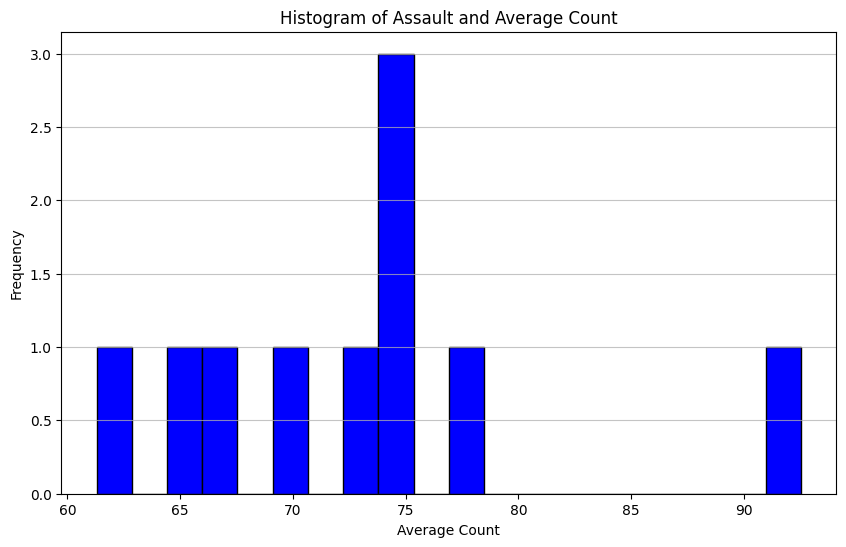

In [85]:
filtered_crimes_against_person_A_pd = filtered_crimes_against_property_10.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_person_A_pd['average_count'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Assault and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [86]:
filtered_crimes_against_person_RF = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against the Person") &
    (crime_df["SUBTYPE"] == "Robbery-Financial")
)
filtered_crimes_against_person_RF.show()

filtered_crimes_against_property_11 = filtered_crimes_against_person_RF.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_11.show()

+----+-----------+--------+--------------------+-----------------+------+-------------+
| _id|REPORT_YEAR|DIVISION|            CATEGORY|          SUBTYPE|COUNT_|COUNT_CLEARED|
+----+-----------+--------+--------------------+-----------------+------+-------------+
|  85|       2019|     D23|Crimes Against th...|Robbery-Financial|     5|            0|
|  98|       2020|     D11|Crimes Against th...|Robbery-Financial|     2|            0|
| 100|       2020|     D52|Crimes Against th...|Robbery-Financial|     1|            0|
| 243|       2016|     D53|Crimes Against th...|Robbery-Financial|     1|            0|
| 269|       2020|     D55|Crimes Against th...|Robbery-Financial|     3|            0|
| 318|       2015|     D23|Crimes Against th...|Robbery-Financial|     1|            0|
| 527|       2023|     D41|Crimes Against th...|Robbery-Financial|     1|            0|
| 638|       2019|     D32|Crimes Against th...|Robbery-Financial|     1|            0|
| 716|       2022|     D22|Crime

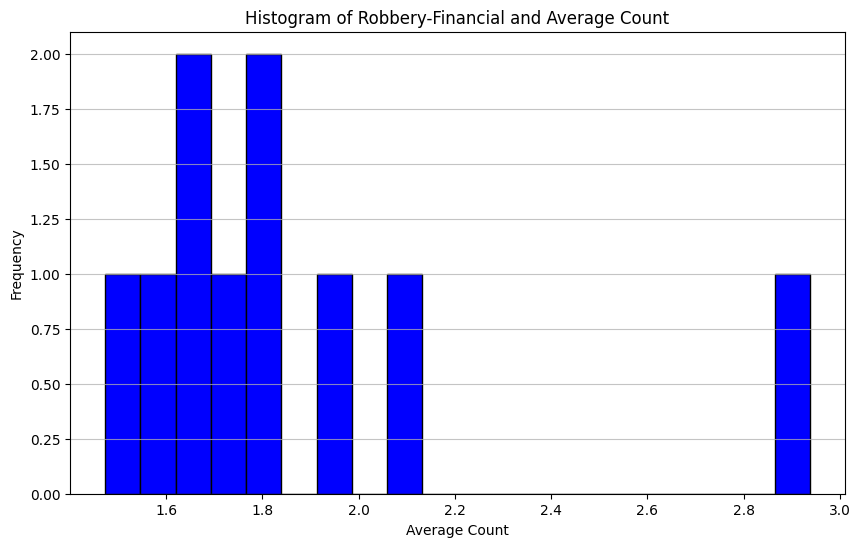

In [87]:
filtered_crimes_against_person_RF_pd = filtered_crimes_against_property_11.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_person_RF_pd['average_count'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Robbery-Financial and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [88]:
filtered_crimes_against_person_RO = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against the Person") &
    (crime_df["SUBTYPE"] == "Robbery-Other")
)
filtered_crimes_against_person_RO.show()

filtered_crimes_against_property_12 = filtered_crimes_against_person_RO.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_12.show()

+---+-----------+--------+--------------------+-------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|      SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+-------------+------+-------------+
| 16|       2014|     D23|Crimes Against th...|Robbery-Other|     1|            0|
| 25|       2014|     D33|Crimes Against th...|Robbery-Other|     1|            0|
| 48|       2021|     D55|Crimes Against th...|Robbery-Other|     3|            0|
| 49|       2019|     D32|Crimes Against th...|Robbery-Other|     3|            0|
|101|       2014|     D53|Crimes Against th...|Robbery-Other|     1|            0|
|109|       2015|     D55|Crimes Against th...|Robbery-Other|     1|            0|
|137|       2021|     D52|Crimes Against th...|Robbery-Other|     3|            0|
|155|       2021|     D43|Crimes Against th...|Robbery-Other|     1|            0|
|213|       2023|     D23|Crimes Against th...|Robbery-Other|     2|            0|
|220

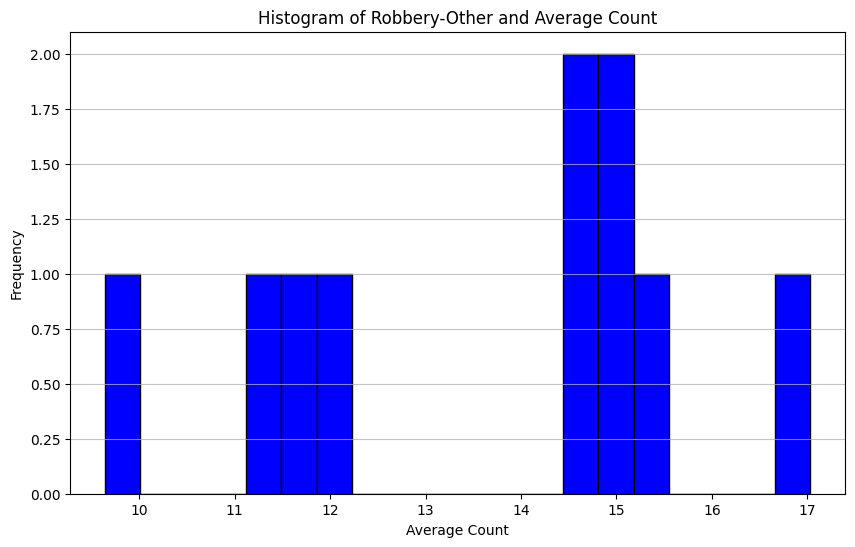

In [89]:
filtered_crimes_against_person_RO_pd = filtered_crimes_against_property_12.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_person_RO_pd['average_count'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Robbery-Other and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [90]:
filtered_crimes_against_person_O = crime_df.filter(
    (crime_df["CATEGORY"] == "Crimes Against the Person") &
    (crime_df["SUBTYPE"] == "Other")
)
filtered_crimes_against_person_O.show()

filtered_crimes_against_property_13 = filtered_crimes_against_person_O.groupBy('REPORT_YEAR','CATEGORY','SUBTYPE').agg(
    F.avg('COUNT_').alias('average_count')
)
filtered_crimes_against_property_13.show()

+----+-----------+--------+--------------------+-------+------+-------------+
| _id|REPORT_YEAR|DIVISION|            CATEGORY|SUBTYPE|COUNT_|COUNT_CLEARED|
+----+-----------+--------+--------------------+-------+------+-------------+
|  77|       2014|     NSA|Crimes Against th...|  Other|     1|            0|
| 200|       2021|     D12|Crimes Against th...|  Other|     1|            0|
| 207|       2017|     D32|Crimes Against th...|  Other|     1|            0|
| 299|       2021|     D12|Crimes Against th...|  Other|     4|            0|
| 432|       2020|     D12|Crimes Against th...|  Other|     4|            0|
| 539|       2014|     D11|Crimes Against th...|  Other|     3|            0|
| 566|       2014|     D51|Crimes Against th...|  Other|     1|            0|
| 632|       2022|     D22|Crimes Against th...|  Other|     1|            0|
| 695|       2018|     D22|Crimes Against th...|  Other|     2|            0|
| 806|       2014|     D22|Crimes Against th...|  Other|     1| 

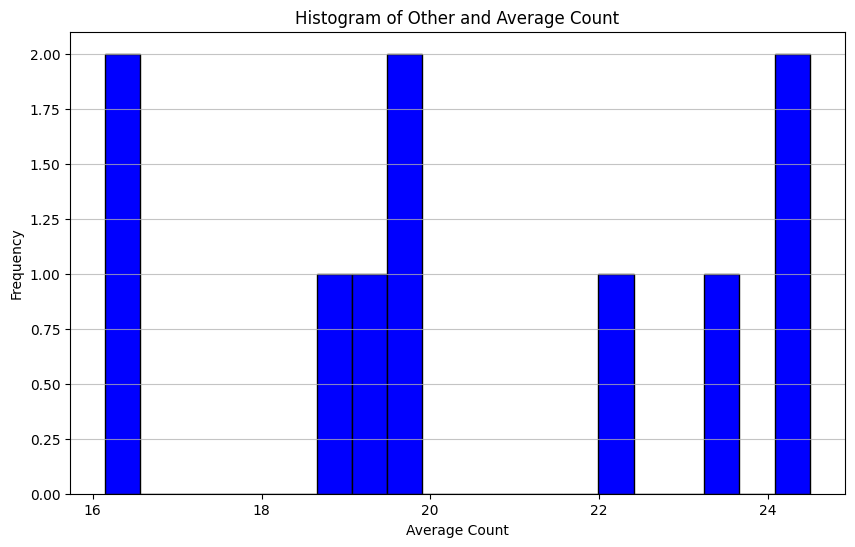

In [91]:
filtered_crimes_against_person_O_pd = filtered_crimes_against_property_13.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_crimes_against_person_O_pd['average_count'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Other and Average Count')
plt.xlabel('Average Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
#Analysis
row_count = crime_df.count()
print(f'Number of rows: {row_count}')
crime_stats = crime_df.groupBy('CATEGORY', 'SUBTYPE').agg(
    F.sum('COUNT_').alias('total_count'),
    F.avg('COUNT_').alias('avg_count'),
    F.min('COUNT_').alias('min_count'),
    F.max('COUNT_').alias('max_count')
)
crime_stats.show()

Number of rows: 32000
+--------------------+--------------------+-----------+------------------+---------+---------+
|            CATEGORY|             SUBTYPE|total_count|         avg_count|min_count|max_count|
+--------------------+--------------------+-----------+------------------+---------+---------+
|Other Federal Sta...|               Other|       2049|2.3715277777777777|        1|       20|
|Crimes Against th...|               Other|      36409| 20.45449438202247|        1|      167|
|Crimes Against Pr...|               Fraud|      91223|  46.6613810741688|        1|      506|
|Crimes Against Pr...|Break & Enter-Apa...|      16063|10.089824120603016|        1|       99|
|Crimes Against th...|   Robbery-Financial|        734|1.8724489795918366|        1|       29|
|Crimes Against Pr...|    Theft Over $5000|      10881| 6.260644418872267|        1|       62|
|Crimes Against Pr...|          Auto Theft|      51122|27.889798145117293|        1|      835|
|Crimes Against Pr...| Break

In [ ]:
crime_df.where(crime_df["REPORT_YEAR"]==2022).show()

+---+-----------+--------+--------------------+--------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|             SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+--------------------+------+-------------+
|  1|       2022|     D32|Crimes Against Pr...|          Auto Theft|    79|            0|
| 10|       2022|     D43|Crimes Against Pr...|    Theft Over $5000|     2|            0|
| 28|       2022|     D41|Crimes Against Pr...|          Auto Theft|     5|            0|
| 37|       2022|     D55|Crimes Against Pr...|    Theft Over $5000|     3|            0|
| 54|       2022|     D23|Crimes Against Pr...|               Fraud|     5|            0|
| 58|       2022|     D11|Other Criminal Co...|Other Criminal Vi...|     1|            0|
| 61|       2022|     D42|Crimes Against Pr...| Break & Enter-House|     9|            0|
| 62|       2022|     D41|Crimes Against Pr...|    Theft Over $5000|     4|            0|
| 63|     

In [ ]:
crime_df.sort("REPORT_YEAR", ascending = False).show()

+---+-----------+--------+--------------------+--------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|             SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+--------------------+------+-------------+
|122|       2023|     D23|Crimes Against Pr...|    Theft Over $5000|     1|            0|
|408|       2023|     D12|Crimes Against Pr...|               Fraud|    13|            0|
|125|       2023|     D55|Crimes Against Pr...|    Theft Over $5000|     4|            0|
|  7|       2023|     D22|Crimes Against Pr...|   Theft Under $5000|     3|            0|
|136|       2023|     D22|Crimes Against Pr...| Break & Enter-Other|     2|            0|
| 33|       2023|     D11|Crimes Against Pr...|    Theft Over $5000|     2|            0|
|152|       2023|     D42|Crimes Against Pr...|          Auto Theft|     2|            0|
| 36|       2023|     D32|Other Federal Sta...|               Other|     2|            0|
|166|     

In [ ]:
crime_df.na.drop().show()

+---+-----------+--------+--------------------+--------------------+------+-------------+
|_id|REPORT_YEAR|DIVISION|            CATEGORY|             SUBTYPE|COUNT_|COUNT_CLEARED|
+---+-----------+--------+--------------------+--------------------+------+-------------+
|  1|       2022|     D32|Crimes Against Pr...|          Auto Theft|    79|            0|
|  2|       2023|     D12|Crimes Against Pr...| Break & Enter-House|     1|            0|
|  3|       2014|     D13|Crimes Against Pr...|          Auto Theft|     7|            0|
|  4|       2021|     NSA|Crimes Against th...|    Sexual Violation|     1|            0|
|  5|       2020|     D53|Crimes Against Pr...|Break & Enter-Apa...|     2|            0|
|  6|       2017|     D43|Crimes Against Pr...|Break & Enter-Apa...|     1|            0|
|  7|       2023|     D22|Crimes Against Pr...|   Theft Under $5000|     3|            0|
|  8|       2018|     D33|Crimes Against Pr...| Break & Enter-Other|     1|            0|
|  9|     

In [100]:
payload = {
    'source': 'google_search',
    'query': 'crimes against the property Toronto',
    'geo_location': 'Canada',
    'parse': True
}
response = requests.request(
    'POST',
    'https://realtime.oxylabs.io/v1/queries',
    auth=('Doob_02_YQS70', '306716812Kk002+'),
    json=payload,
)

pprint(response.json())

{'job': {'_links': [{'href': 'http://data.oxylabs.io/v1/queries/7411344360098242561',
                     'method': 'GET',
                     'rel': 'self'},
                    {'href': 'http://data.oxylabs.io/v1/queries/7411344360098242561/results',
                     'method': 'GET',
                     'rel': 'results'},
                    {'href_list': ['http://data.oxylabs.io/v1/queries/7411344360098242561/results/1/content'],
                     'method': 'GET',
                     'rel': 'results-content'},
                    {'href': 'http://data.oxylabs.io/v1/queries/7411344360098242561/results?type=raw',
                     'method': 'GET',
                     'rel': 'results-html'},
                    {'href_list': ['http://data.oxylabs.io/v1/queries/7411344360098242561/results/1/content?type=raw'],
                     'method': 'GET',
                     'rel': 'results-content-html'},
                    {'href': 'http://data.oxylabs.io/v1/queries/741134436

In [99]:
payload2 = {
    'source': 'google_search',
    'query': 'crimes against the person Toronto',
    'geo_location': 'Canada',
    'parse': True
}
response2 = requests.request(
    'POST',
    'https://realtime.oxylabs.io/v1/queries',
    auth=('Doob_02_YQS70', '306716812Kk002+'),
    json=payload,
)

pprint(response2.json())

{'job': {'_links': [{'href': 'http://data.oxylabs.io/v1/queries/7411344293450776577',
                     'method': 'GET',
                     'rel': 'self'},
                    {'href': 'http://data.oxylabs.io/v1/queries/7411344293450776577/results',
                     'method': 'GET',
                     'rel': 'results'},
                    {'href_list': ['http://data.oxylabs.io/v1/queries/7411344293450776577/results/1/content'],
                     'method': 'GET',
                     'rel': 'results-content'},
                    {'href': 'http://data.oxylabs.io/v1/queries/7411344293450776577/results?type=raw',
                     'method': 'GET',
                     'rel': 'results-html'},
                    {'href_list': ['http://data.oxylabs.io/v1/queries/7411344293450776577/results/1/content?type=raw'],
                     'method': 'GET',
                     'rel': 'results-content-html'},
                    {'href': 'http://data.oxylabs.io/v1/queries/741134429